RUN SBI-SGM  with autism

parameters order is  :taue,taui,tauG,speed,alpha,gii,gei (In second)

## Import some pkgs

In [1]:
import sys
sys.path.append("../mypkg")

import scipy
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import trange
from scipy.io import loadmat
from functools import partial
from easydict import EasyDict as edict
import importlib


In [2]:
# SBI and torch
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi import analysis
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils as sutils

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.multivariate_normal import MultivariateNormal

In [3]:
# my own fns
#import utils.standardize
#importlib.reload(utils.standardize);
from brain import Brain
from constants import RES_ROOT, DATA_ROOT, FIG_ROOT
from utils.misc import load_pkl, save_pkl
from utils.reparam import theta_raw_2out, logistic_np, logistic_torch
from utils.stable import paras_table_check
from utils.standardize import stdz_psd, stdz_vec, minmax_vec, psd_2tr
from sgm.sgm import SGM

In [4]:
plt.style.use(FIG_ROOT/"base.mplstyle")

## Data and some parameters

In [5]:
# SC and dist
temp_info = loadmat(DATA_ROOT/"BC_consensus_DK_14.mat")
SC_temp = temp_info["SC_template"]
Dist_temp = temp_info["Dist_template"]

# PSD
all_MEG_psd_p = DATA_ROOT/"MEG_DK_Atlas/Autism_MEG_all_PSD.mat"
all_MEG_psd = loadmat(all_MEG_psd_p)
freqs = all_MEG_psd["data_1"][0, 0][1].reshape(-1)

# data information
data_info_path = DATA_ROOT/'Autism_Demopoulos_DiagnosisAgeSex.csv'
data_info = pd.read_csv(data_info_path)

In [6]:
# these parameters are constant in this file
_paras = edict()
_paras.fs = 600
_paras.freq_limit = [2, 40]
_paras.keep_idxs = np.bitwise_and(freqs>=_paras.freq_limit[0], freqs<=_paras.freq_limit[1])
_paras.freqs = freqs[np.bitwise_and(freqs>=_paras.freq_limit[0], freqs<=_paras.freq_limit[1])]

In [7]:
# these parameters may changes during tuning processing
paras = edict()

paras.num_nodes = 86 # Number of cortical (68) + subcortical nodes
paras.par_low = np.asarray([0.005,0.005,0.005,5, 0.1,0.001,0.001])
paras.par_high = np.asarray([0.03, 0.20, 0.03,10,  1,    2,  0.7]) # change spped upper bound from 20 to 10
paras.prior_bds = np.array([paras.par_low, paras.par_high]).T
paras.names = ["Taue", "Taui", "TauC", "Speed", "alpha", "gii", "gei"]
paras.prior_sd = 10
paras.add_v = 0.05

paras.SBI_paras = edict()
paras.SBI_paras.num_prior_sps = int(2e4)
paras.SBI_paras.density_model = "nsf"
paras.SBI_paras.num_round = 3
paras.SBI_paras.noise_sd = 1.2

## Some fns

In [8]:
def avg_pearson_r(rec_vecs, obs_vecs, is_roi=False):
    assert rec_vecs.shape[0] == 68
    all_vs = []
    for ix in range(68):
        rec_vec, obs_vec = rec_vecs[ix, :], obs_vecs[ix, :]
        pearson_v = scipy.stats.pearsonr(rec_vec, obs_vec)[0]
        all_vs.append(pearson_v)
    if is_roi:
        return np.array(all_vs)
    else:
        return np.mean(all_vs)

In [9]:
def get_mode(x):
    kde_est = scipy.stats.gaussian_kde(x)
    xs = np.linspace(x.min(), x.max(), 500)
    ys = kde_est(xs)
    return xs[np.argmax(ys)]

In [10]:
def _filter_unstable(theta_raw, prior_bds, x=None):
    """This fn is to remove unstable SGM parameters
        args: theta_raw: parameters: num of sps x dim
                order: ['Taue', 'Taui', 'TauC', 'Speed', 'alpha', 'gii', 'gei']
    """
    theta = _theta_raw_2out(theta_raw.numpy(), prior_bds)
    stable_idxs = paras_table_check(theta)
    
    # keep stable sps only
    theta_raw_stable = theta_raw[stable_idxs==0]
    if x is not None:
        x_stable = x[stable_idxs==0]
        return theta_raw_stable, x_stable
    else:
        return theta_raw_stable

In [11]:
# fn for reparemetering
_map_fn_torch = partial(logistic_torch, k=0.1)
_theta_raw_2out = partial(theta_raw_2out, map_fn=partial(logistic_np, k=0.1))

## Prepare for SBI

In [12]:

def _add_v2con(cur_ind_conn, add_v_ratio):
    cur_ind_conn = cur_ind_conn.copy()
    add_v = np.max(cur_ind_conn)*add_v_ratio # tuning 0.1
    np.fill_diagonal(cur_ind_conn[:34, 34:68], np.diag(cur_ind_conn[:34, 34:68]) + add_v)
    np.fill_diagonal(cur_ind_conn[34:68, :34], np.diag(cur_ind_conn[34:68, :34]) + add_v)
    np.fill_diagonal(cur_ind_conn[68:77, 77:], np.diag(cur_ind_conn[68:77, 77:]) + add_v)
    np.fill_diagonal(cur_ind_conn[77:, 68:77], np.diag(cur_ind_conn[77:, 68:77]) + add_v)
    return cur_ind_conn

SC_temp = _add_v2con(SC_temp, paras.add_v)

In [13]:
# New SC and Dist mat
# the brain we used.
# Note that we do not need to re-order as the order is correct. Cortical first, them subcortical ROIs
brain = Brain.Brain()
brain.connectome =  SC_temp
brain.distance_matrix =  Dist_temp
brain.bi_symmetric_c()
brain.reduce_extreme_dir()

# SGM model
sgmmodel = SGM(brain.reducedConnectome, brain.distance_matrix, _paras.freqs)

In [14]:
# HCP SC
brain = Brain.Brain()
brain.add_connectome(DATA_ROOT) # grabs distance matrix
brain.reorder_connectome(brain.connectome, brain.distance_matrix)
brain.connectome =  _add_v2con(brain.connectome, paras.add_v)
brain.bi_symmetric_c()
brain.reduce_extreme_dir()

# SGM model
sgmmodel = SGM(brain.reducedConnectome, brain.distance_matrix, _paras.freqs)

In [15]:
def simulator(params, noise_sd, sgmmodel, prior_bds):
    """The function to simulate samples
    """
    params_trans = []
    for param, prior_bd in zip(params, prior_bds):
        param_trans =  _map_fn_torch(param)*(prior_bd[1]-prior_bd[0]) + prior_bd[0]
        params_trans.append(param_trans)
    params_trans = torch.tensor(params_trans)
    
    psd = sgmmodel.run_local_coupling_forward(params_trans)
    psd = psd[:68, :]
    std_psd_DB = psd_2tr(psd)
    psd_fs = std_psd_DB.flatten()
    noise =  np.random.randn(*psd_fs.shape)*noise_sd 
    return psd_fs+noise

In [16]:
def simulator_gen(params, sgmmodel, prior_bds):
    """The function to posterior samples
        No Noise, No dB or stdz
    """
    params_trans = []
    for param, prior_bd in zip(params, prior_bds):
        param_trans =  _map_fn_torch(param)*(prior_bd[1]-prior_bd[0]) + prior_bd[0]
        params_trans.append(param_trans)
    params_trans = torch.tensor(params_trans)
    
    psd = sgmmodel.run_local_coupling_forward(params_trans)
    psd = psd[:68, :]
    psd = psd_2tr(psd)
    return psd

In [17]:
prior = MultivariateNormal(loc=torch.zeros(7), covariance_matrix=torch.eye(7)*(paras.prior_sd**2))

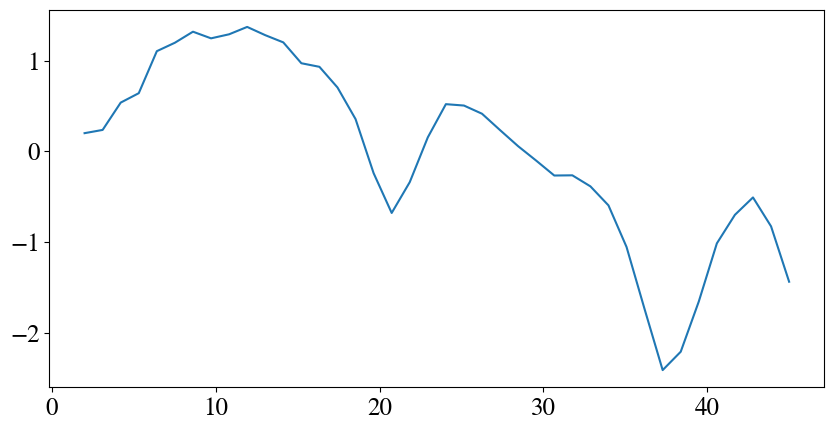

In [82]:
# To plot the PSD from 36-MEG data
import xarray as xr
ind_psd_xr = xr.open_dataarray(DATA_ROOT/'individual_psd_reordered_matlab.nc')
ind_psd = ind_psd_xr.values
freqs_tmp = ind_psd_xr["frequencies"].values

sub_idx = 0
obs_psd_tmp = psd_2tr(ind_psd[:, :, sub_idx])

#for roi_idx in range(68):
#    plt.plot(freqs_tmp, obs_psd_tmp[roi_idx])
plt.plot(freqs_tmp, obs_psd_tmp[1])

## SBI

### Universal

In [ ]:
simulator_sp = partial(simulator, 
                           noise_sd=paras.SBI_paras.noise_sd, 
                           prior_bds=paras.prior_bds, sgmmodel=sgmmodel)
simulator_wrapper, prior = prepare_for_sbi(simulator_sp, prior)
inference = SNPE(prior=prior, density_estimator=paras.SBI_paras.density_model)
theta, x = simulate_for_sbi(simulator_wrapper, prior,
          num_simulations=int(paras.SBI_paras.num_prior_sps*1.5),
          num_workers=20)
theta_stable, x_stable = _filter_unstable(theta, paras.prior_bds, x)
theta_stable, x_stable = theta_stable[:paras.SBI_paras.num_prior_sps, :], x_stable[:paras.SBI_paras.num_prior_sps, :]
del theta, x
print(x_stable.shape)
density_estimator = inference.append_simulations(
                     theta_stable, x_stable, proposal=prior
                     ).train()
posterior = inference.build_posterior(density_estimator)
save_fil = f"posterior_" + \
             f"num{paras.SBI_paras.num_prior_sps}_" + \
             f"density{paras.SBI_paras.density_model}_" + \
             f"noise_sd{paras.SBI_paras.noise_sd*100:.0f}_" +\
             f"addv{paras.add_v*100:.0f}.pkl"
        
save_pkl(RES_ROOT/save_fil, posterior)

Running 30000 simulations in 30000 batches.:   0%|          | 0/30000 [00:00<?, ?it/s]

In [83]:
# check the simulator fn
simulator_sp = partial(simulator, 
                           noise_sd=paras.SBI_paras.noise_sd, 
                           prior_bds=paras.prior_bds, sgmmodel=sgmmodel)
tt = prior.sample_n(10)
ttt = simulator_sp(tt[0])

def moving_average(sequence, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(sequence, window, 'same')
vec1 = ttt[40:80]
vec2 = moving_average(vec1, 3)

/opt/conda/lib/python3.9/site-packages/torch/distributions/distribution.py:166: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


### MR

In [26]:
for cur_ind_idx in range(0, 36):
    print(cur_ind_idx)
    
    simulator_sp = partial(simulator, 
                           noise_sd=paras.SBI_paras.noise_sd, 
                           prior_bds=paras.prior_bds, sgmmodel=sgmmodel)
    simulator_wrapper, prior = prepare_for_sbi(simulator_sp, prior)
    inference = SNPE(prior=prior, density_estimator=paras.SBI_paras.density_model)
    proposal = prior 
    
    #the observed data
    cur_obs_FC = np.abs(true_FC[:, :, cur_ind_idx])
    curX = torch.Tensor(_minmax_vec(cur_obs_FC[np.triu_indices(68, k = 1)]))
    
    #num_spss = [10000, 10000, 5000]
    for ix in range(paras.SBI_paras.num_round):
        theta, x = simulate_for_sbi(simulator_wrapper, proposal,
                                    num_simulations=int(paras.SBI_paras.num_prior_sps*2),
                                    num_workers=20)
        theta_stable, x_stable = _filter_unstable(theta, paras.prior_bds, x)
        theta_stable, x_stable = theta_stable[:paras.SBI_paras.num_prior_sps, :], x_stable[:paras.SBI_paras.num_prior_sps, :]
        print(x_stable.shape)
        density_estimator = inference.append_simulations(
                            theta_stable, x_stable, proposal=proposal
                            ).train()
        posterior = inference.build_posterior(density_estimator)
        
        
        #update proposal 
        proposal = posterior.set_default_x(curX)
    
    #MR: multi-round
    save_fil = f"posteriorMRmul_{paras.fc_type}_" + \
               f"num{paras.SBI_paras.num_prior_sps}_" + \
               f"density{paras.SBI_paras.density_model}_" + \
               f"MR{paras.SBI_paras.num_round}_" + \
               f"noise_sd{paras.SBI_paras.noise_sd*100:.0f}_" +\
               f"addv{paras.add_v*100:.0f}" +\
               f"/ind{cur_ind_idx}.pkl"
        
    save_pkl(RES_ROOT/save_fil, proposal)

0


Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

torch.Size([1000, 2278])
 Neural network successfully converged after 23 epochs.

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

/home/hujin/.local/lib/python3.9/site-packages/nflows/transforms/lu.py:80: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2189.)
  outputs, _ = torch.triangular_solve(


Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

torch.Size([1000, 2278])
Using SNPE-C with atomic loss
 Neural network successfully converged after 24 epochs.

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

torch.Size([1000, 2278])
Using SNPE-C with atomic loss
 Neural network successfully converged after 26 epochs./data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC1/SBI-SGM-FC/notebooks/new_bds/../../mypkg/../results/newbds_posteriorMRmul_alpha_num1000_densitynsf_MR3_noise_sd20_addv5
Create a folder /data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC1/SBI-SGM-FC/notebooks/new_bds/../../mypkg/../results/newbds_posteriorMRmul_alpha_num1000_densitynsf_MR3_noise_sd20_addv5
Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC1/SBI-SGM-FC/notebooks/new_bds/../../mypkg/../results/newbds_posteriorMRmul_alpha_num1000_densitynsf_MR3_noise_sd20_addv5/ind0.pkl
1


Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

torch.Size([1000, 2278])
 Neural network successfully converged after 23 epochs.

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

torch.Size([1000, 2278])
Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 35

KeyboardInterrupt: 

## Analysis

### Universal

In [18]:
def moving_average(sequence, win_size):
    window = np.ones(int(win_size))/float(win_size)
    return np.convolve(sequence, window, 'same')

def moving_average_mat (mat, win_size):
    """This fn is to do moving_avg in a mat with shape (num_vec, len_vec)
    """
    new_mats = []
    for vec in mat:
        new_mats.append(moving_average(vec, win_size))
    new_mats = np.array(new_mats)
    return new_mats

In [19]:
save_fil = f"posterior_" + \
             f"num{paras.SBI_paras.num_prior_sps}_" + \
             f"density{paras.SBI_paras.density_model}_" + \
             f"noise_sd{paras.SBI_paras.noise_sd*100:.0f}_" +\
             f"addv{paras.add_v*100:.0f}.pkl"
save_fil

uni_posterior = load_pkl(RES_ROOT/save_fil)

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM-Autism/notebooks/../mypkg/../results/posterior_num20000_densitynsf_noise_sd120_addv5.pkl


In [20]:
post_spss = []
rec_psds = []
obs_psds = []
for ix in trange(78):
    obs_psd = all_MEG_psd[f"data_{ix+1}"][0, 0][0][:, _paras.keep_idxs]
    obs_psd = psd_2tr(obs_psd)
    obs_psd1 = moving_average_mat(obs_psd, 5)
    
    cur_X = obs_psd.flatten()
    cur_X = torch.Tensor(cur_X)
    
    # first way, point estimate
    # post_sps_raw = uni_posterior.sample((10000, ), x=cur_X, max_sampling_batch_size=10000)
    # post_sps_raw_stable = _filter_unstable(post_sps_raw, paras.prior_bds)
    # post_sps = _theta_raw_2out(post_sps_raw_stable, paras.prior_bds)
    # #point_est = post_sps.median(axis=0).values
    # point_est = post_sps.mean(axis=0)
    # rec_psd = sgmmodel.run_local_coupling_forward(point_est.numpy())
    # rec_psd = psd_2tr(rec_psd[:68, :])
    # post_spss.append(post_sps.numpy())
    
    # second way, Bayesian
    uni_posterior_X = uni_posterior.set_default_x(cur_X)
    simulator_gen_sp = partial(simulator_gen, 
                               prior_bds=paras.prior_bds, sgmmodel=sgmmodel)
    simulator_wrapper, _ = prepare_for_sbi(simulator_gen_sp, prior)
    theta, rec_psds_fb = simulate_for_sbi(simulator_wrapper, uni_posterior_X,
              num_simulations=100, 
              num_workers=20)
    rec_psd = torch.mean(rec_psds_fb, axis=0).reshape(68, -1).numpy()
    
    rec_psds.append(rec_psd)
    obs_psds.append(obs_psd)

  0%|                                                                                                                                                   | 0/78 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

/home/hujin/.local/lib/python3.9/site-packages/nflows/transforms/lu.py:80: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2189.)
  outputs, _ = torch.triangular_solve(


Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

  1%|█▊                                                                                                                                         | 1/78 [00:13<17:49, 13.89s/it]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

  3%|███▌                                                                                                                                       | 2/78 [00:26<16:23, 12.95s/it]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

  4%|█████▎                                                                                                                                     | 3/78 [00:38<15:37, 12.49s/it]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

  5%|███████▏                                                                                                                                   | 4/78 [00:50<15:13, 12.35s/it]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

  6%|████████▉                                                                                                                                  | 5/78 [01:02<14:55, 12.26s/it]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

  8%|██████████▋                                                                                                                                | 6/78 [01:14<14:36, 12.17s/it]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

  9%|████████████▍                                                                                                                              | 7/78 [01:26<14:31, 12.28s/it]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

 10%|██████████████▎                                                                                                                            | 8/78 [01:39<14:24, 12.36s/it]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

 12%|████████████████                                                                                                                           | 9/78 [01:51<14:06, 12.27s/it]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

 13%|█████████████████▋                                                                                                                        | 10/78 [02:03<13:52, 12.24s/it]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

 14%|███████████████████▍                                                                                                                      | 11/78 [02:15<13:40, 12.24s/it]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

 15%|█████████████████████▏                                                                                                                    | 12/78 [02:27<13:24, 12.18s/it]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

 17%|███████████████████████                                                                                                                   | 13/78 [02:40<13:11, 12.18s/it]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

 18%|████████████████████████▊                                                                                                                 | 14/78 [02:52<12:58, 12.17s/it]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

 19%|██████████████████████████▌                                                                                                               | 15/78 [03:04<12:48, 12.19s/it]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

 21%|████████████████████████████▎                                                                                                             | 16/78 [03:16<12:36, 12.20s/it]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

 22%|██████████████████████████████                                                                                                            | 17/78 [03:29<12:26, 12.24s/it]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

 23%|███████████████████████████████▊                                                                                                          | 18/78 [03:41<12:10, 12.18s/it]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

 24%|█████████████████████████████████▌                                                                                                        | 19/78 [03:53<11:57, 12.16s/it]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

 26%|███████████████████████████████████▍                                                                                                      | 20/78 [04:05<11:43, 12.13s/it]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

 27%|█████████████████████████████████████▏                                                                                                    | 21/78 [04:17<11:38, 12.26s/it]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

 28%|██████████████████████████████████████▉                                                                                                   | 22/78 [04:30<11:25, 12.24s/it]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

 29%|████████████████████████████████████████▋                                                                                                 | 23/78 [04:42<11:15, 12.28s/it]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

 31%|██████████████████████████████████████████▍                                                                                               | 24/78 [04:54<11:01, 12.26s/it]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

 32%|████████████████████████████████████████████▏                                                                                             | 25/78 [05:06<10:47, 12.21s/it]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

 33%|██████████████████████████████████████████████                                                                                            | 26/78 [05:18<10:34, 12.20s/it]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

 35%|███████████████████████████████████████████████▊                                                                                          | 27/78 [05:31<10:21, 12.19s/it]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

 36%|█████████████████████████████████████████████████▌                                                                                        | 28/78 [05:43<10:07, 12.14s/it]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

 37%|███████████████████████████████████████████████████▎                                                                                      | 29/78 [05:55<09:55, 12.15s/it]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

 38%|█████████████████████████████████████████████████████                                                                                     | 30/78 [06:07<09:45, 12.20s/it]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

 40%|██████████████████████████████████████████████████████▊                                                                                   | 31/78 [06:19<09:36, 12.26s/it]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

 41%|████████████████████████████████████████████████████████▌                                                                                 | 32/78 [06:32<09:23, 12.26s/it]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

 42%|██████████████████████████████████████████████████████████▍                                                                               | 33/78 [06:44<09:12, 12.28s/it]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

 44%|████████████████████████████████████████████████████████████▏                                                                             | 34/78 [06:56<09:00, 12.27s/it]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

 45%|█████████████████████████████████████████████████████████████▉                                                                            | 35/78 [07:08<08:45, 12.23s/it]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

 46%|███████████████████████████████████████████████████████████████▋                                                                          | 36/78 [07:21<08:34, 12.24s/it]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

 47%|█████████████████████████████████████████████████████████████████▍                                                                        | 37/78 [07:33<08:20, 12.20s/it]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

 49%|███████████████████████████████████████████████████████████████████▏                                                                      | 38/78 [07:45<08:10, 12.26s/it]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████████████████████████████████                                                                     | 39/78 [07:57<07:54, 12.18s/it]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

 51%|██████████████████████████████████████████████████████████████████████▊                                                                   | 40/78 [08:10<07:48, 12.33s/it]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

 53%|████████████████████████████████████████████████████████████████████████▌                                                                 | 41/78 [08:22<07:32, 12.23s/it]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

 54%|██████████████████████████████████████████████████████████████████████████▎                                                               | 42/78 [08:34<07:17, 12.16s/it]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

 55%|████████████████████████████████████████████████████████████████████████████                                                              | 43/78 [08:46<07:06, 12.19s/it]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

 56%|█████████████████████████████████████████████████████████████████████████████▊                                                            | 44/78 [08:58<06:54, 12.18s/it]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

 58%|███████████████████████████████████████████████████████████████████████████████▌                                                          | 45/78 [09:11<06:42, 12.19s/it]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████▍                                                        | 46/78 [09:23<06:31, 12.25s/it]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████▏                                                      | 47/78 [09:35<06:19, 12.23s/it]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████▉                                                     | 48/78 [09:47<06:06, 12.21s/it]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████▋                                                   | 49/78 [09:59<05:53, 12.20s/it]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 50/78 [10:12<05:43, 12.25s/it]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



#### All MEG

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 5422.50it/s]


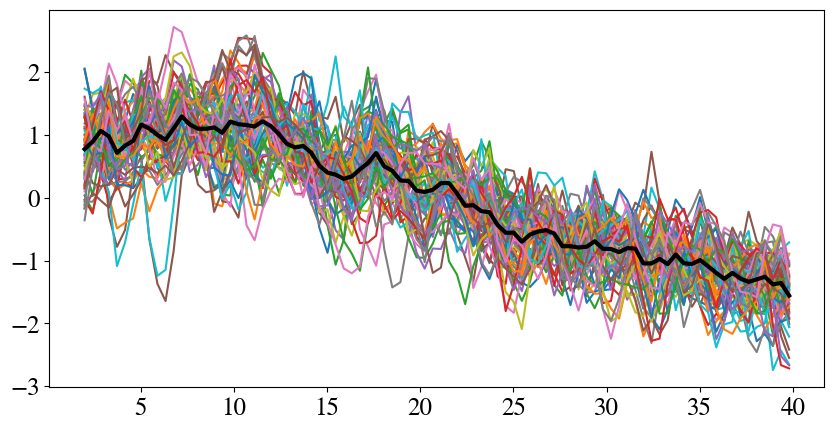

In [30]:
# Just to plot the obs psd 
obs_psds = []
for ix in trange(78):
    obs_psd = all_MEG_psd[f"data_{ix+1}"][0, 0][0][:, _paras.keep_idxs]
    obs_psd = psd_2tr(obs_psd)
    obs_psds.append(obs_psd)
obs_psds = np.array(obs_psds)

sub_idx = 10
#roi_idx = 2
for roi_idx in range(68):
    plt.plot(_paras.freqs, obs_psds[sub_idx, roi_idx, :])
plt.plot(_paras.freqs, obs_psds[sub_idx, :, :].mean(axis=0),lw=3, color="black")
#plt.plot(_paras.freqs, moving_average(obs_psds[sub_idx, roi_idx, :], 10))
#plt.plot(_paras.freqs, obs_psds[sub_idx, :, :].mean(axis=0))
#plt.plot(_paras.freqs, obs_psds.mean(axis=(0, 1)), label="MEG")

In [21]:
rec_psds = np.array(rec_psds)
obs_psds = np.array(obs_psds)

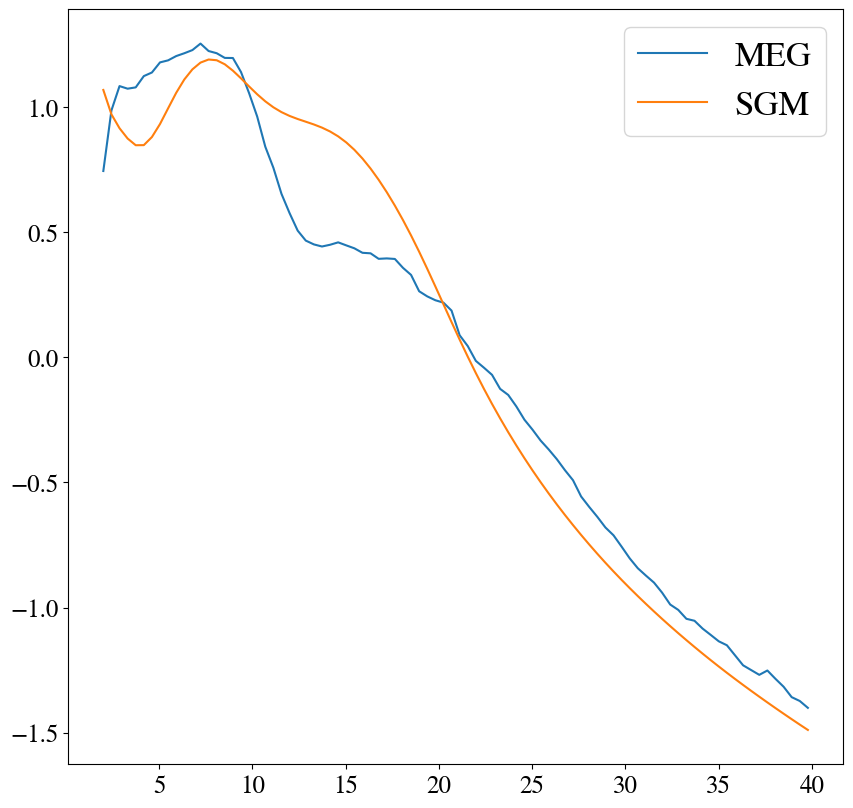

In [22]:
plt.figure(figsize=[10, 10])
plt.plot(_paras.freqs, obs_psds.mean(axis=(0, 1)), label="MEG")
plt.plot(_paras.freqs, rec_psds.mean(axis=(0, 1)), label="SGM")
plt.legend()

#### Autism vs Ctrl

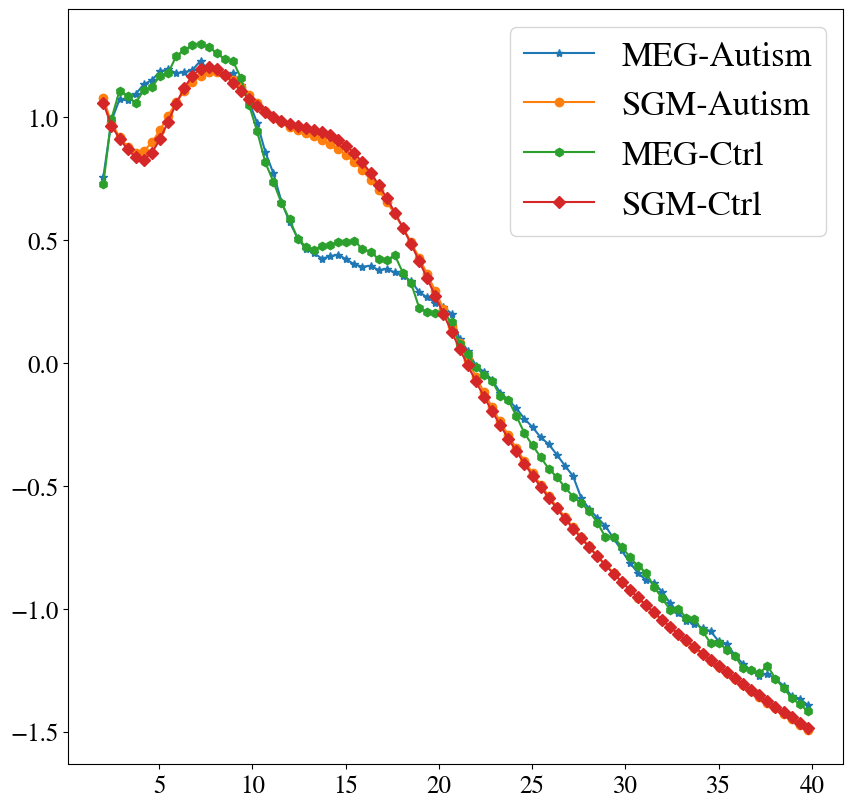

In [23]:
plt.figure(figsize=[10, 10])
ASD_rec_psds = rec_psds[data_info["Diagnosis"]==1]
Ctrl_rec_psds = rec_psds[data_info["Diagnosis"]==0]

ASD_obs_psds = obs_psds[data_info["Diagnosis"]==1]
Ctrl_obs_psds = obs_psds[data_info["Diagnosis"]==0]

plt.plot(_paras.freqs, ASD_obs_psds.mean(axis=(0, 1)), "-*", label="MEG-Autism")
plt.plot(_paras.freqs, ASD_rec_psds.mean(axis=(0, 1)), "-o", label="SGM-Autism")
plt.plot(_paras.freqs, Ctrl_obs_psds.mean(axis=(0, 1)), "-h", label="MEG-Ctrl")
plt.plot(_paras.freqs, Ctrl_rec_psds.mean(axis=(0, 1)), "-D", label="SGM-Ctrl")
plt.legend()

[0.8412804793444192, 0.8560711873081202]


Ttest_indResult(statistic=-1.3760057336826255, pvalue=0.17286120304251834)

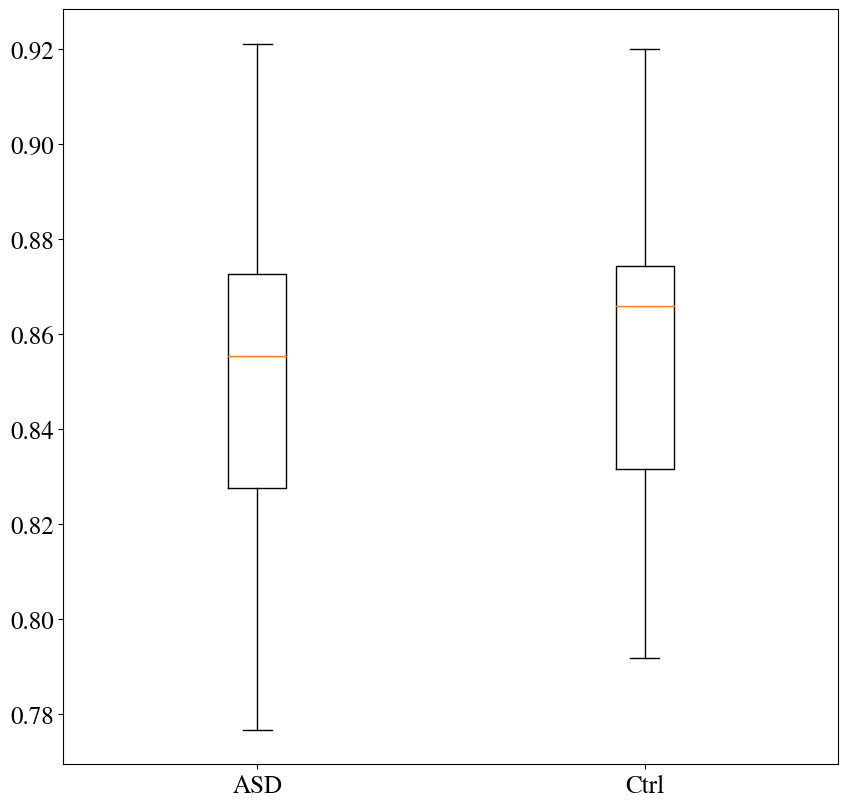

In [24]:
avg_rs = []
for rec_vecs, obs_vecs in zip(rec_psds, obs_psds):
    avg_rs.append(avg_pearson_r(rec_vecs, obs_vecs, 0))
avg_rs = np.array(avg_rs)
plt.figure(figsize=[10, 10])
plt.boxplot([avg_rs[data_info["Diagnosis"]==1], avg_rs[data_info["Diagnosis"]==0]], 
           labels=["ASD", "Ctrl"], showfliers=False);
print([avg_rs[data_info["Diagnosis"]==1].mean(), avg_rs[data_info["Diagnosis"]==0].mean()])
scipy.stats.ttest_ind(avg_rs[data_info["Diagnosis"]==1],  avg_rs[data_info["Diagnosis"]==0])


In [50]:
post_spss9000 = np.array([post_sps[:8000] for post_sps in post_spss])
ASD_post_spss =  post_spss9000[data_info["Diagnosis"]==1].reshape(-1, 7)
Ctrl_post_spss =  post_spss9000[data_info["Diagnosis"]==0].reshape(-1, 7)

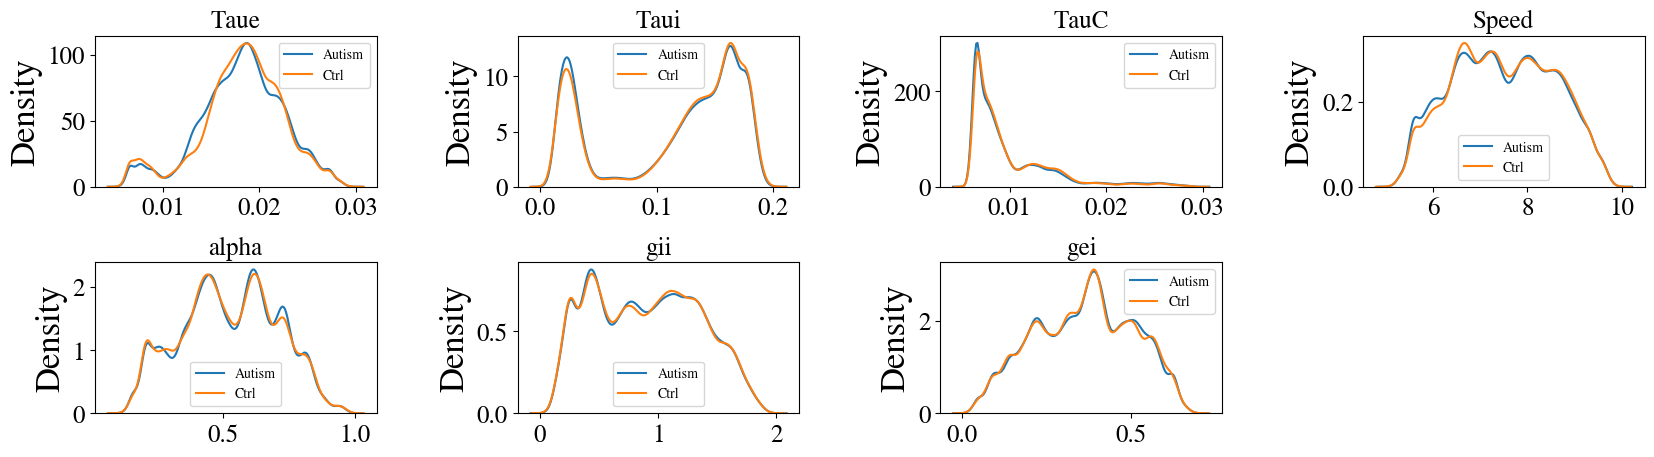

In [51]:
plt.figure(figsize=[20, 5])
plt.subplots_adjust(wspace=0.5, hspace=0.5)
for ix in range(7):
    plt.subplot(2, 4, ix+1)
    sns.kdeplot(ASD_post_spss[:, ix], label="Autism")
    sns.kdeplot(Ctrl_post_spss[:, ix],label="Ctrl")
    plt.legend(fontsize=10)
    plt.title(paras.names[ix])

## Results

### HCP+larger taue + 4-40

- add 0.05 to SC 

- noise 1.2 

- 50,000 sps

#### All MEG

In [75]:
rec_psds = np.array(rec_psds)
obs_psds = np.array(obs_psds)

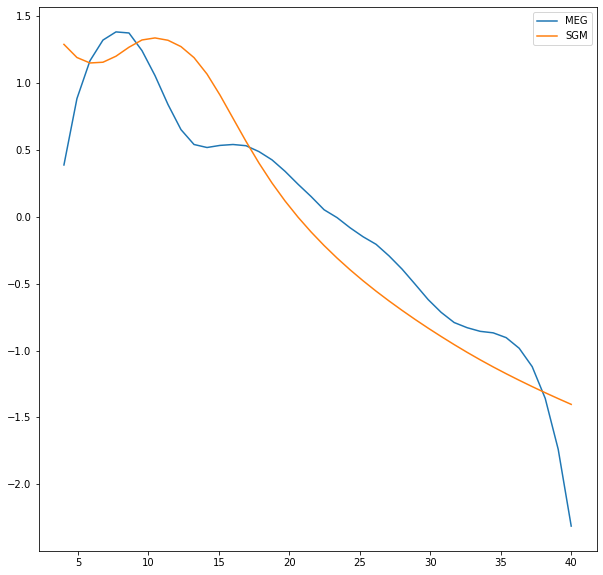

In [76]:
plt.figure(figsize=[10, 10])
plt.plot(_paras.freqs, obs_psds.mean(axis=(0, 1)), label="MEG")
plt.plot(_paras.freqs, rec_psds.mean(axis=(0, 1)), label="SGM")
plt.legend()

#### Autism vs Ctrl

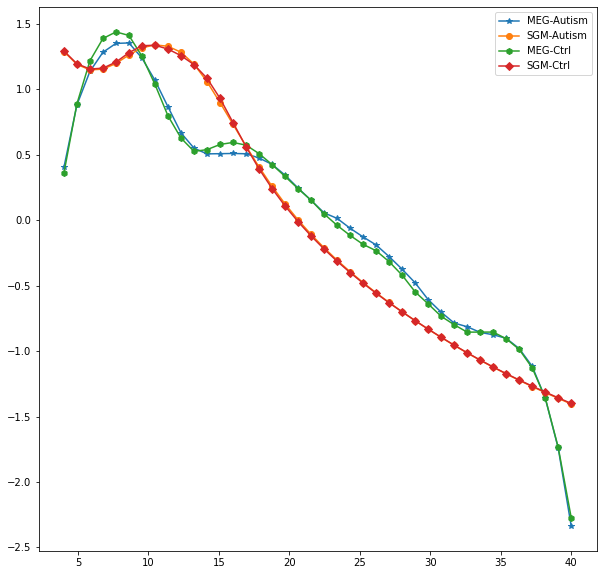

In [77]:
plt.figure(figsize=[10, 10])
ASD_rec_psds = rec_psds[data_info["Diagnosis"]==1]
Ctrl_rec_psds = rec_psds[data_info["Diagnosis"]==0]

ASD_obs_psds = obs_psds[data_info["Diagnosis"]==1]
Ctrl_obs_psds = obs_psds[data_info["Diagnosis"]==0]

plt.plot(_paras.freqs, ASD_obs_psds.mean(axis=(0, 1)), "-*", label="MEG-Autism")
plt.plot(_paras.freqs, ASD_rec_psds.mean(axis=(0, 1)), "-o", label="SGM-Autism")
plt.plot(_paras.freqs, Ctrl_obs_psds.mean(axis=(0, 1)), "-h", label="MEG-Ctrl")
plt.plot(_paras.freqs, Ctrl_rec_psds.mean(axis=(0, 1)), "-D", label="SGM-Ctrl")
plt.legend()

[0.8245469278392358, 0.8368328171974074]


Ttest_indResult(statistic=-1.1345130267008932, pvalue=0.260145090563942)

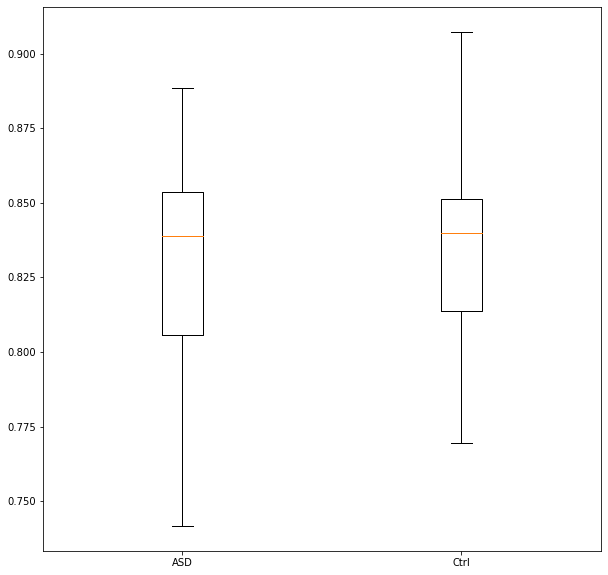

In [78]:
avg_rs = []
for rec_vecs, obs_vecs in zip(rec_psds, obs_psds):
    avg_rs.append(avg_pearson_r(rec_vecs, obs_vecs, 0))
avg_rs = np.array(avg_rs)
plt.figure(figsize=[10, 10])
plt.boxplot([avg_rs[data_info["Diagnosis"]==1], avg_rs[data_info["Diagnosis"]==0]], 
           labels=["ASD", "Ctrl"], showfliers=False);
print([avg_rs[data_info["Diagnosis"]==1].mean(), avg_rs[data_info["Diagnosis"]==0].mean()])
scipy.stats.ttest_ind(avg_rs[data_info["Diagnosis"]==1],  avg_rs[data_info["Diagnosis"]==0])


In [79]:
post_spss9000 = np.array([post_sps[:8000] for post_sps in post_spss])
ASD_post_spss =  post_spss9000[data_info["Diagnosis"]==1].reshape(-1, 7)
Ctrl_post_spss =  post_spss9000[data_info["Diagnosis"]==0].reshape(-1, 7)

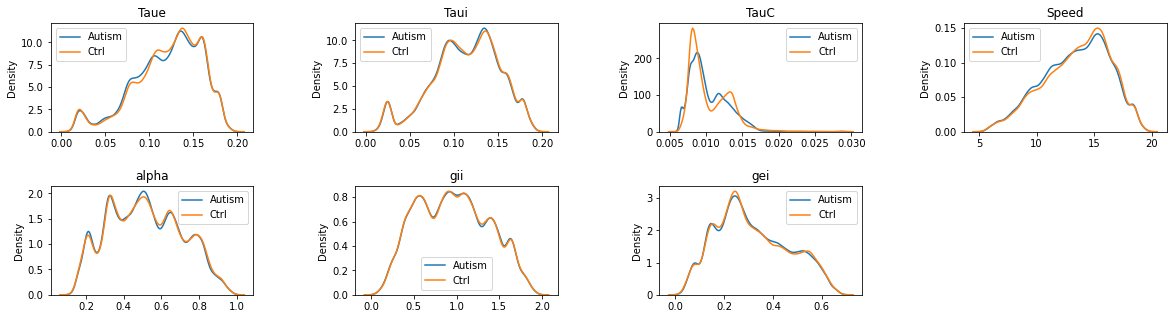

In [80]:
plt.figure(figsize=[20, 5])
plt.subplots_adjust(wspace=0.5, hspace=0.5)
for ix in range(7):
    plt.subplot(2, 4, ix+1)
    sns.kdeplot(ASD_post_spss[:, ix], label="Autism")
    sns.kdeplot(Ctrl_post_spss[:, ix],label="Ctrl")
    plt.legend()
    plt.title(paras.names[ix])

### BenSC +larger taue + 4-40

- add 0.05 to SC 

- noise 1.2 

- 50,000 sps

#### All MEG

In [20]:
rec_psds = np.array(rec_psds)
obs_psds = np.array(obs_psds)

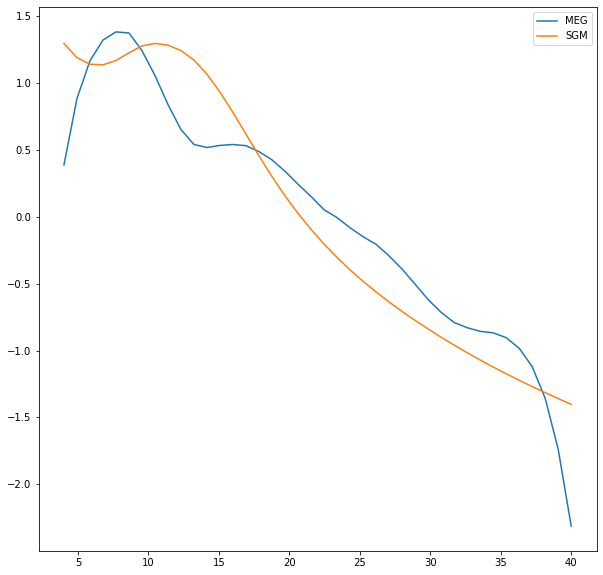

In [21]:
plt.figure(figsize=[10, 10])
plt.plot(_paras.freqs, obs_psds.mean(axis=(0, 1)), label="MEG")
plt.plot(_paras.freqs, rec_psds.mean(axis=(0, 1)), label="SGM")
plt.legend()

#### Autism vs Ctrl

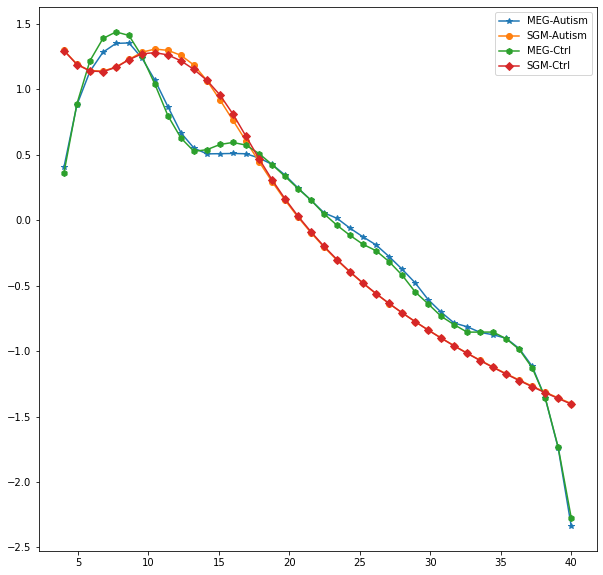

In [22]:
plt.figure(figsize=[10, 10])
ASD_rec_psds = rec_psds[data_info["Diagnosis"]==1]
Ctrl_rec_psds = rec_psds[data_info["Diagnosis"]==0]

ASD_obs_psds = obs_psds[data_info["Diagnosis"]==1]
Ctrl_obs_psds = obs_psds[data_info["Diagnosis"]==0]

plt.plot(_paras.freqs, ASD_obs_psds.mean(axis=(0, 1)), "-*", label="MEG-Autism")
plt.plot(_paras.freqs, ASD_rec_psds.mean(axis=(0, 1)), "-o", label="SGM-Autism")
plt.plot(_paras.freqs, Ctrl_obs_psds.mean(axis=(0, 1)), "-h", label="MEG-Ctrl")
plt.plot(_paras.freqs, Ctrl_rec_psds.mean(axis=(0, 1)), "-D", label="SGM-Ctrl")
plt.legend()

[0.822589307088496, 0.8363255791229399]


Ttest_indResult(statistic=-1.3046148471748427, pvalue=0.19596084251532028)

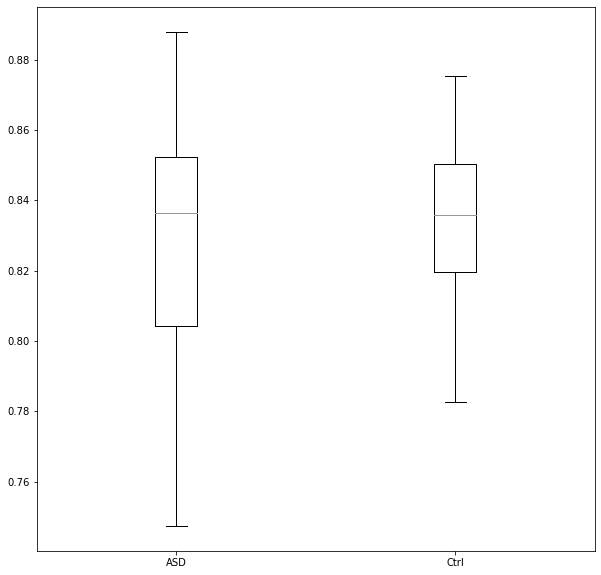

In [23]:
avg_rs = []
for rec_vecs, obs_vecs in zip(rec_psds, obs_psds):
    avg_rs.append(avg_pearson_r(rec_vecs, obs_vecs, 0))
avg_rs = np.array(avg_rs)
plt.figure(figsize=[10, 10])
plt.boxplot([avg_rs[data_info["Diagnosis"]==1], avg_rs[data_info["Diagnosis"]==0]], 
           labels=["ASD", "Ctrl"], showfliers=False);
print([avg_rs[data_info["Diagnosis"]==1].mean(), avg_rs[data_info["Diagnosis"]==0].mean()])
scipy.stats.ttest_ind(avg_rs[data_info["Diagnosis"]==1],  avg_rs[data_info["Diagnosis"]==0])


In [24]:
post_spss9000 = np.array([post_sps[:8000] for post_sps in post_spss])
ASD_post_spss =  post_spss9000[data_info["Diagnosis"]==1].reshape(-1, 7)
Ctrl_post_spss =  post_spss9000[data_info["Diagnosis"]==0].reshape(-1, 7)

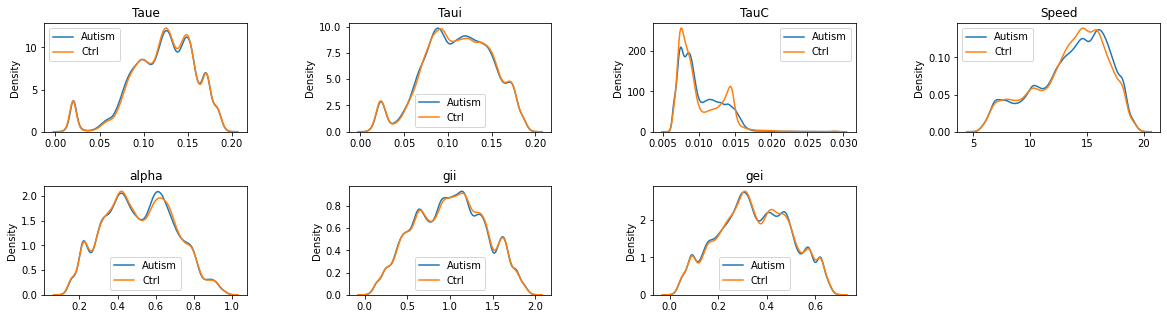

In [25]:
plt.figure(figsize=[20, 5])
plt.subplots_adjust(wspace=0.5, hspace=0.5)
for ix in range(7):
    plt.subplot(2, 4, ix+1)
    sns.kdeplot(ASD_post_spss[:, ix], label="Autism")
    sns.kdeplot(Ctrl_post_spss[:, ix],label="Ctrl")
    plt.legend()
    plt.title(paras.names[ix])